# Two Moons: Tackling Bimodal Posteriors

_Authors: Lars Kühmichel, Marvin Schmitt, Valentin Pratz, Stefan T. Radev_

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# Set to your favorite backend
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"
else:
    print(f"Using '{os.environ['KERAS_BACKEND']}' backend")

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf

2025-04-29 08:45:08.361053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745916308.373731   71278 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745916308.378030   71278 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 08:45:08.393220: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 08:45:09.884415: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

## Simulator<a class="anchor" id="simulator"></a>

In [4]:
from bayesflow.simulators.benchmark_simulators import TwoMoons

simulator = TwoMoons()

Let's generate some data to see what the simulator does:

In [5]:
# generate 3 random draws from the joint distribution p(r, alpha, theta, x)
sample_data = simulator.sample(3)

In [6]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['parameters', 'observables'])
Types of sample_data values:
	 {'parameters': <class 'numpy.ndarray'>, 'observables': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'parameters': (3, 2), 'observables': (3, 2)}


BayesFlow also provides this simulator and a collection of others in the `bayesflow.benchmarks` module.

## Adapter

In [7]:
adapter = (
    bf.adapters.Adapter.create_default(inference_variables=["parameters"])
    # standardize data variables to zero mean and unit variance
    .standardize(exclude="inference_variables")
    # rename the variables to match the required approximator inputs
    .rename("observables", "inference_conditions")
)
adapter

Adapter([0: ToArray -> 1: ConvertDType -> 2: Concatenate(['parameters'] -> 'inference_variables') -> 3: Standardize(exclude=['inference_variables']) -> 4: Rename('observables' -> 'inference_conditions')])

## Dataset

For this example, we will sample our training data ahead of time and use offline training with a very small number of epochs. In actual applications, you usually want to train much longer in order to max our performance.

In [8]:
num_batches_per_epoch = 512
num_validation_sets = 300
batch_size = 64
epochs = 50

In [9]:
validation_data = simulator.sample(num_validation_sets)

## Training a neural network to approximate all posteriors

In [10]:
diffusion_model = bf.experimental.DiffusionModel(
    subnet="mlp",
    subnet_kwargs={"dropout": 0.0, "widths": (256,)*6}, # override default dropout = 0.05 and widths = (256,)*5
    noise_schedule="edm",
    prediction_type="F",
)

### Basic Workflow
We can hide many of the traditional deep learning steps (e.g., specifying a learning rate and an optimizer) within a `Workflow` object. This object just wraps everything together and includes some nice utility functions for training and *in silico* validation.

In [11]:
diffusion_model_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=diffusion_model,
    initial_learning_rate=1e-3,
)

### Training

We are ready to train our deep posterior approximator on the two moons example. We use the utility function `fit_offline`, which wraps the approximator's super flexible `fit` method.

In [12]:
history = diffusion_model_workflow.fit_online(
    epochs=epochs,
    num_batches_per_epoch=num_batches_per_epoch,
    batch_size=batch_size, 
    validation_data=validation_data,
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3.5213 - loss/inference_loss: 3.5213 - val_loss: 1.9474 - val_loss/inference_loss: 1.9474
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4044 - loss/inference_loss: 1.4044 - val_loss: 0.9011 - val_loss/inference_loss: 0.9011
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8857 - loss/inference_loss: 0.8857 - val_loss: 0.5213 - val_loss/inference_loss: 0.5213
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7341 - loss/inference_loss: 0.7341 - val_loss: 0.7266 - val_loss/inference_loss: 0.7266
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7106 - loss/inference_loss: 0.7106 - val_loss: 0.5299 - val_loss/inference_loss: 0.5299
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6149 - loss/inference_loss: 0.6149 - val_loss: 0.3700 - val_loss/inference_loss: 0.3700
Epoch 7/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6752 - loss/inference_loss: 0.6752 - v

(-0.5, 0.5)

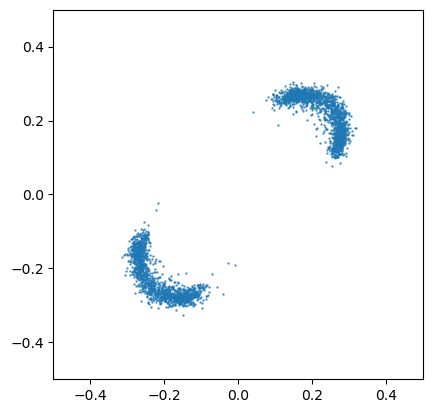

In [13]:
samples = diffusion_model_workflow.sample(num_samples=3000, conditions={"observables":np.array([[0.0, 0.0]], dtype=np.float32)}, steps=1000)
plt.scatter(samples["parameters"][0, :, 0], samples["parameters"][0, :, 1], alpha=0.75, s=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])

(-0.5, 0.5)

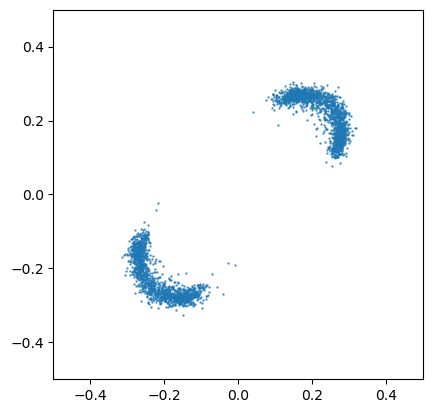

In [14]:
plt.scatter(samples["parameters"][0, :, 0], samples["parameters"][0, :, 1], alpha=0.75, s=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])

## EDM only

In [15]:
from collections.abc import Sequence
import keras
from keras import ops

from bayesflow.types import Tensor, Shape
import bayesflow as bf
from bayesflow.networks import InferenceNetwork
from bayesflow.utils.serialization import serialize, deserialize, serializable

from bayesflow.utils import (
    expand_right_as,
    find_network,
    jacobian_trace,
    weighted_mean,
    integrate,
)


@serializable
class EDM(InferenceNetwork):
    """Diffusion Model as described as Elucidated Diffusion Model in [1].

    [1] Elucidating the Design Space of Diffusion-Based Generative Models: arXiv:2206.00364
    """

    MLP_DEFAULT_CONFIG = {
        "widths": (256, 256, 256, 256, 256),
        "activation": "mish",
        "kernel_initializer": "he_normal",
        "residual": True,
        "dropout": 0.0,
        "spectral_normalization": False,
    }

    INTEGRATE_DEFAULT_CONFIG = {
        "method": "euler",
        "steps": 100,
    }

    def __init__(
        self,
        subnet: str | type = "mlp",
        integrate_kwargs: dict[str, any] = None,
        subnet_kwargs: dict[str, any] = None,
        sigma_data=1.0,
        **kwargs,
    ):
        """
        Initializes a diffusion model with configurable subnet architecture.

        This model learns a transformation from a Gaussian latent distribution to a target distribution using a
        specified subnet type, which can be an MLP or a custom network.

        The integration steps can be customized with additional parameters available in the respective
        configuration dictionary.

        Parameters
        ----------
        subnet : str or type, optional
            The architecture used for the transformation network. Can be "mlp" or a custom
            callable network. Default is "mlp".
        integrate_kwargs : dict[str, any], optional
            Additional keyword arguments for the integration process. Default is None.
        subnet_kwargs : dict[str, any], optional
            Keyword arguments passed to the subnet constructor or used to update the default MLP settings.
        sigma_data : float, optional
            Averaged standard deviation of the target distribution. Default is 1.0.
        **kwargs
            Additional keyword arguments passed to the subnet and other components.
        """

        super().__init__(base_distribution=None, **kwargs)

        # tunable parameters not intended to be modified by the average user
        self.max_sigma = kwargs.get("max_sigma", 80.0)
        self.min_sigma = kwargs.get("min_sigma", 1e-4)
        self.rho = kwargs.get("rho", 7)

        # latent distribution (not configurable)
        self.base_distribution = bf.distributions.DiagonalNormal(
            mean=0.0, std=self.max_sigma
        )
        self.integrate_kwargs = self.INTEGRATE_DEFAULT_CONFIG | (integrate_kwargs or {})

        self.sigma_data = sigma_data

        self.seed_generator = keras.random.SeedGenerator()

        subnet_kwargs = subnet_kwargs or {}
        if subnet == "mlp":
            subnet_kwargs = self.MLP_DEFAULT_CONFIG | subnet_kwargs

        self.subnet = find_network(subnet, **subnet_kwargs)
        self.output_projector = keras.layers.Dense(units=None, bias_initializer="zeros")

    def build(self, xz_shape: Shape, conditions_shape: Shape = None) -> None:
        self.base_distribution.build(xz_shape)
        self.output_projector.units = xz_shape[-1]
        input_shape = list(xz_shape)

        # construct time vector
        input_shape[-1] += 1
        if conditions_shape is not None:
            input_shape[-1] += conditions_shape[-1]

        input_shape = tuple(input_shape)

        self.subnet.build(input_shape)
        out_shape = self.subnet.compute_output_shape(input_shape)
        self.output_projector.build(out_shape)

    def get_config(self):
        base_config = super().get_config()
        config = {
            "integrate_kwargs": self.integrate_kwargs,
            "subnet": self.subnet,
            "sigma_data": self.sigma_data,
        }
        return base_config | serialize(config)

    @classmethod
    def from_config(cls, config, custom_objects=None):
        return cls(**deserialize(config, custom_objects=custom_objects))

    def _c_skip_fn(self, sigma):
        return self.sigma_data**2 / (sigma**2 + self.sigma_data**2)

    def _c_out_fn(self, sigma):
        return sigma * self.sigma_data / ops.sqrt(self.sigma_data**2 + sigma**2)

    def _c_in_fn(self, sigma):
        return 1.0 / ops.sqrt(sigma**2 + self.sigma_data**2)

    def _c_noise_fn(self, sigma):
        return 0.25 * ops.log(sigma)

    def _denoiser_fn(
        self,
        xz: Tensor,
        sigma: Tensor,
        conditions: Tensor = None,
        training: bool = False,
    ):
        # calculate output of the network
        c_in = self._c_in_fn(sigma)
        c_noise = self._c_noise_fn(sigma)
        xz_pre = c_in * xz
        if conditions is None:
            xtc = keras.ops.concatenate([xz_pre, c_noise], axis=-1)
        else:
            xtc = keras.ops.concatenate([xz_pre, c_noise, conditions], axis=-1)
        out = self.output_projector(
            self.subnet(xtc, training=training), training=training
        )
        return self._c_skip_fn(sigma) * xz + self._c_out_fn(sigma) * out

    def velocity(
        self,
        xz: Tensor,
        sigma: float | Tensor,
        conditions: Tensor = None,
        training: bool = False,
    ) -> Tensor:
        # transform sigma vector into correct shape
        sigma = keras.ops.convert_to_tensor(sigma, dtype=keras.ops.dtype(xz))
        sigma = expand_right_as(sigma, xz)
        sigma = keras.ops.broadcast_to(sigma, keras.ops.shape(xz)[:-1] + (1,))

        d = self._denoiser_fn(xz, sigma, conditions, training=training)
        return (xz - d) / sigma

    def _velocity_trace(
        self,
        xz: Tensor,
        sigma: Tensor,
        conditions: Tensor = None,
        max_steps: int = None,
        training: bool = False,
    ) -> (Tensor, Tensor):
        def f(x):
            return self.velocity(
                x, sigma=sigma, conditions=conditions, training=training
            )

        v, trace = jacobian_trace(
            f, xz, max_steps=max_steps, seed=self.seed_generator, return_output=True
        )

        return v, keras.ops.expand_dims(trace, axis=-1)

    def _forward(
        self,
        x: Tensor,
        conditions: Tensor = None,
        density: bool = False,
        training: bool = False,
        **kwargs,
    ) -> Tensor | tuple[Tensor, Tensor]:
        integrate_kwargs = self.integrate_kwargs | kwargs
        if isinstance(integrate_kwargs["steps"], int):
            # set schedule for specified number of steps
            integrate_kwargs["steps"] = self._integration_schedule(
                integrate_kwargs["steps"], dtype=ops.dtype(x)
            )
        if density:

            def deltas(time, xz):
                v, trace = self._velocity_trace(
                    xz, sigma=time, conditions=conditions, training=training
                )
                return {"xz": v, "trace": trace}

            state = {
                "xz": x,
                "trace": keras.ops.zeros(
                    keras.ops.shape(x)[:-1] + (1,), dtype=keras.ops.dtype(x)
                ),
            }
            state = integrate(
                deltas,
                state,
                **integrate_kwargs,
            )

            z = state["xz"]
            log_density = self.base_distribution.log_prob(z) + keras.ops.squeeze(
                state["trace"], axis=-1
            )

            return z, log_density

        def deltas(time, xz):
            return {
                "xz": self.velocity(
                    xz, sigma=time, conditions=conditions, training=training
                )
            }

        state = {"xz": x}
        state = integrate(
            deltas,
            state,
            **integrate_kwargs,
        )

        z = state["xz"]

        return z

    def _inverse(
        self,
        z: Tensor,
        conditions: Tensor = None,
        density: bool = False,
        training: bool = False,
        **kwargs,
    ) -> Tensor | tuple[Tensor, Tensor]:
        integrate_kwargs = self.integrate_kwargs | kwargs
        if isinstance(integrate_kwargs["steps"], int):
            # set schedule for specified number of steps
            integrate_kwargs["steps"] = self._integration_schedule(
                integrate_kwargs["steps"], inverse=True, dtype=ops.dtype(z)
            )
        if density:

            def deltas(time, xz):
                v, trace = self._velocity_trace(
                    xz, sigma=time, conditions=conditions, training=training
                )
                return {"xz": v, "trace": trace}

            state = {
                "xz": z,
                "trace": keras.ops.zeros(
                    keras.ops.shape(z)[:-1] + (1,), dtype=keras.ops.dtype(z)
                ),
            }
            state = integrate(deltas, state, **integrate_kwargs)

            x = state["xz"]
            log_density = self.base_distribution.log_prob(z) - keras.ops.squeeze(
                state["trace"], axis=-1
            )

            return x, log_density

        def deltas(time, xz):
            return {
                "xz": self.velocity(
                    xz, sigma=time, conditions=conditions, training=training
                )
            }

        state = {"xz": z}
        state = integrate(
            deltas,
            state,
            **integrate_kwargs,
        )

        x = state["xz"]

        return x

    def compute_metrics(
        self,
        x: Tensor | Sequence[Tensor, ...],
        conditions: Tensor = None,
        sample_weight: Tensor = None,
        stage: str = "training",
    ) -> dict[str, Tensor]:
        training = stage == "training"
        if not self.built:
            xz_shape = keras.ops.shape(x)
            conditions_shape = (
                None if conditions is None else keras.ops.shape(conditions)
            )
            self.build(xz_shape, conditions_shape)
        # hyper-parameters for sampling the noise level
        p_mean = -1.2
        p_std = 1.2

        # sample log-noise level
        log_sigma = p_mean + p_std * keras.random.normal(
            ops.shape(x)[:1], dtype=ops.dtype(x), seed=self.seed_generator
        )
        # noise level with shape (batch_size, 1)
        sigma = ops.exp(log_sigma)[:, None]

        # generate noise vector
        z = sigma * keras.random.normal(
            ops.shape(x), dtype=ops.dtype(x), seed=self.seed_generator
        )

        # calculate preconditioning
        c_skip = self._c_skip_fn(sigma)
        c_out = self._c_out_fn(sigma)
        c_in = self._c_in_fn(sigma)
        c_noise = self._c_noise_fn(sigma)
        xz_pre = c_in * (x + z)

        # calculate output of the network
        if conditions is None:
            xtc = keras.ops.concatenate([xz_pre, c_noise], axis=-1)
        else:
            xtc = keras.ops.concatenate([xz_pre, c_noise, conditions], axis=-1)

        out = self.output_projector(
            self.subnet(xtc, training=training), training=training
        )

        # Calculate loss:
        lam = 1 / c_out[:, 0] ** 2
        effective_weight = lam * c_out[:, 0] ** 2
        unweighted_loss = ops.mean(
            (out - 1 / c_out * (x - c_skip * (x + z))) ** 2, axis=-1
        )
        loss = effective_weight * unweighted_loss
        loss = weighted_mean(loss, sample_weight)

        base_metrics = super().compute_metrics(x, conditions, sample_weight, stage)
        return base_metrics | {"loss": loss}

    def _integration_schedule(self, steps, inverse=False, dtype=None):
        def sigma_i(i, steps):
            N = steps + 1
            return (
                self.max_sigma ** (1 / self.rho)
                + (i / (N - 1))
                * (self.min_sigma ** (1 / self.rho) - self.max_sigma ** (1 / self.rho))
            ) ** self.rho

        steps = sigma_i(ops.arange(steps + 1, dtype=dtype), steps)
        if not inverse:
            steps = ops.flip(steps)
        return steps

In [16]:
adapter_edm = (
    bf.adapters.Adapter.create_default(inference_variables=["parameters"])
    # standardize data variables to zero mean and unit variance
    .standardize(exclude="inference_variables")
    # rename the variables to match the required approximator inputs
    .rename("observables", "inference_conditions")
)
adapter_edm

Adapter([0: ToArray -> 1: ConvertDType -> 2: Concatenate(['parameters'] -> 'inference_variables') -> 3: Standardize(exclude=['inference_variables']) -> 4: Rename('observables' -> 'inference_conditions')])

## Dataset

For this example, we will sample our training data ahead of time and use offline training with a very small number of epochs. In actual applications, you usually want to train much longer in order to max our performance.

num_training_batches = 512
num_validation_sets = 300
batch_size = 64
epochs = 50

training_data = simulator.sample(num_training_batches * batch_size)
validation_data = simulator.sample(num_validation_sets)

## Training a neural network to approximate all posteriors

The next step is to set up the neural network that will approximate the posterior $p(\theta\,|\,x)$.

We choose **Flow Matching** [1, 2] as the backbone architecture for this example, as it can deal well with the multimodal nature of the posteriors that some observables imply.

* [1] Lipman, Y., Chen, R. T., Ben-Hamu, H., Nickel, M., & Le, M. Flow Matching for Generative Modeling. In *The Eleventh International Conference on Learning Representations*.

* [2] Wildberger, J. B., Dax, M., Buchholz, S., Green, S. R., Macke, J. H., & Schölkopf, B. Flow Matching for Scalable Simulation-Based Inference. In *Thirty-seventh Conference on Neural Information Processing Systems*.

In [17]:
edm = EDM(
    subnet="mlp", 
    subnet_kwargs={"dropout": 0.0, "widths": (256,)*6}, # override default dropout = 0.05 and widths = (256,)*5
)

This inference network is just a general Flow Matching backbone, not yet adapted to the specific inference task at hand (i.e., posterior appproximation). To achieve this adaptation, we combine the network with our data adapter, which together form an `approximator`. In this case, we need a `ContinuousApproximator` since the target we want to approximate is the posterior of the *continuous* parameter vector $\theta$.

### Basic Workflow
We can hide many of the traditional deep learning steps (e.g., specifying a learning rate and an optimizer) within a `Workflow` object. This object just wraps everything together and includes some nice utility functions for training and *in silico* validation.

In [18]:
edm_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter_edm,
    inference_network=edm,
    initial_learning_rate=1e-3
)

### Training

We are ready to train our deep posterior approximator on the two moons example. We use the utility function `fit_offline`, which wraps the approximator's super flexible `fit` method.

diffusion_model_workflow.approximator.build_from_data(diffusion_model_workflow.adapter(validation_data))

In [19]:
edm_history = edm_workflow.fit_online(
    epochs=epochs,
    num_batches_per_epoch=num_batches_per_epoch,
    batch_size=batch_size, 
    validation_data=validation_data,
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8323 - loss/inference_loss: 0.8323 - val_loss: 0.6503 - val_loss/inference_loss: 0.6503
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4613 - loss/inference_loss: 0.4613 - val_loss: 0.4215 - val_loss/inference_loss: 0.4215
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3344 - loss/inference_loss: 0.3344 - val_loss: 0.3557 - val_loss/inference_loss: 0.3557
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3013 - loss/inference_loss: 0.3013 - val_loss: 0.2316 - val_loss/inference_loss: 0.2316
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2833 - loss/inference_loss: 0.2833 - val_loss: 0.1944 - val_loss/inference_loss: 0.1944
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2795 - loss/inference_loss: 0.2795 - val_loss: 0.2124 - val_loss/inference_loss: 0.2124
Epoch 7/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2705 - loss/inference_loss: 0.2705 - v

(-0.5, 0.5)

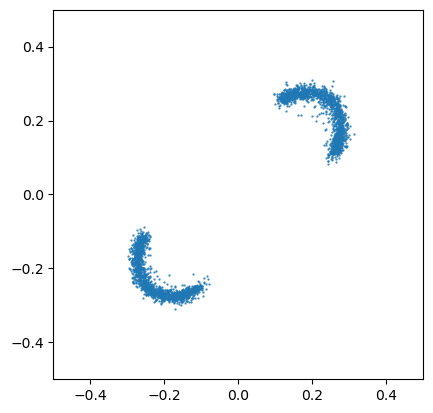

In [20]:
edm_samples = edm_workflow.sample(num_samples=3000, conditions={"observables":np.array([[0.0, 0.0]], dtype=np.float32)})
plt.scatter(edm_samples["parameters"][0, :, 0], edm_samples["parameters"][0, :, 1], alpha=0.75, s=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])

(-0.5, 0.5)

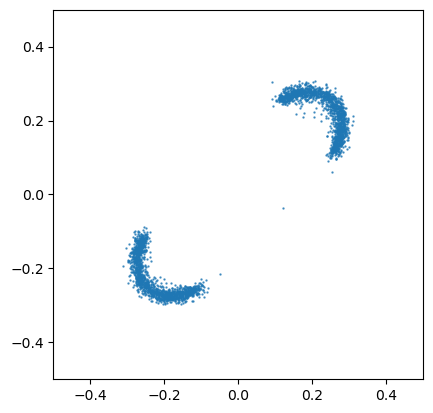

In [21]:
edm_samples = edm_workflow.sample(num_samples=3000, conditions={"observables":np.array([[0.0, 0.0]], dtype=np.float32)}, steps=1000)
plt.scatter(edm_samples["parameters"][0, :, 0], edm_samples["parameters"][0, :, 1], alpha=0.75, s=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])

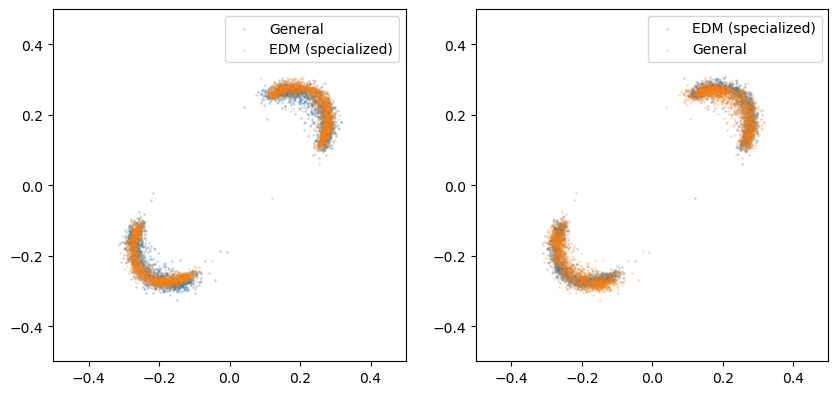

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].scatter(samples["parameters"][0, :, 0], samples["parameters"][0, :, 1], alpha=0.2, s=1, label="General")
axs[0].scatter(
    edm_samples["parameters"][0, :, 0],
    edm_samples["parameters"][0, :, 1],
    alpha=0.2,
    s=1,
    label="EDM (specialized)",
)

axs[1].scatter(edm_samples["parameters"][0, :, 0], edm_samples["parameters"][0, :, 1], alpha=0.2, s=1, label="EDM (specialized)")
axs[1].scatter(
    samples["parameters"][0, :, 0],
    samples["parameters"][0, :, 1],
    alpha=0.2,
    s=1,
    label="General",
)

for ax in axs:
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([-0.5, 0.5])
    ax.legend()